# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 50

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, path):
        self.path = path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        dataframe = dataframe.copy()
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        dataframe = dataframe.copy()
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print('--- Adding new features')
        dataframe = dataframe.copy()
        
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        dataframe = dataframe.copy()
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))
        print(f'\nDataset size: {dataframe.shape}\n\n')

        return dataframe


    def load(self):
        print(f'Loading data from {self.path}')
        dataframe = pd.read_csv(self.path, index_col='id')
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        return dataframe

In [4]:
train = DataLoader(TRAIN_PATH).load()
test = DataLoader(TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data from /kaggle/input/playground-series-s4e7/train.csv
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 1404.39 MB
------ Memory usage after: 351.10 MB
------ Decreased memory usage by 75.0%

Dataset size: (11504798, 15)


Loading data from /kaggle/input/playground-series-s4e7/test.csv
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 877.75 MB
------ Memory usage after: 226.75 MB
------ Decreased memory usage by 74.2%

Dataset size: (7669866, 14)




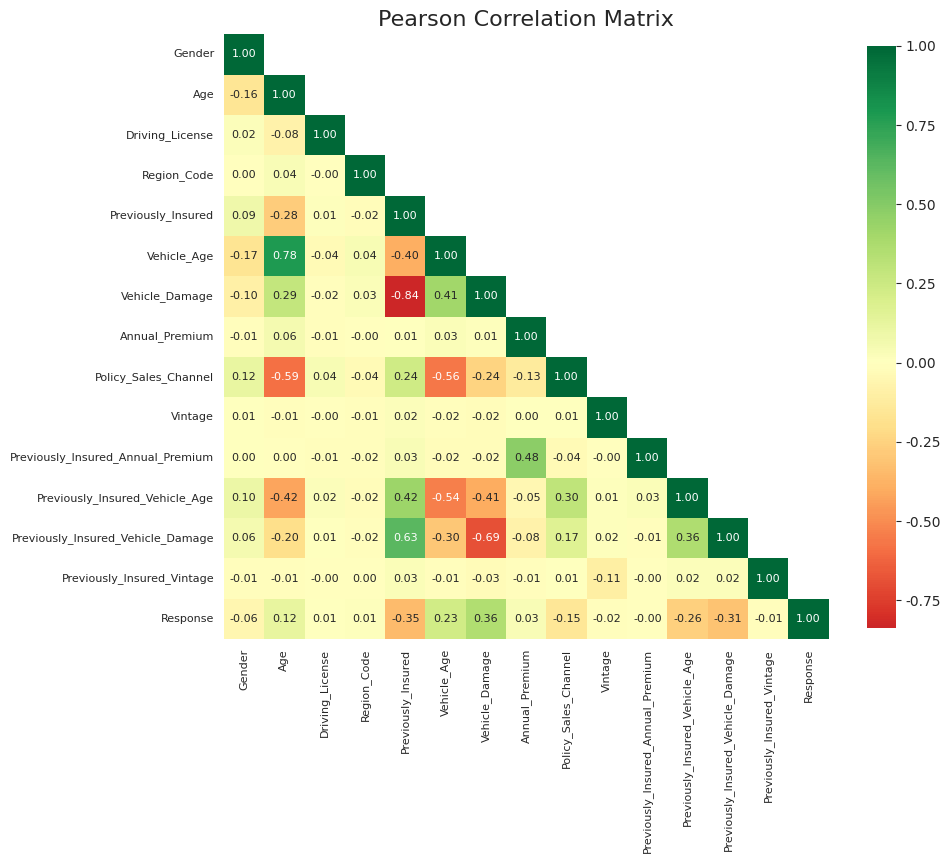

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 10))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

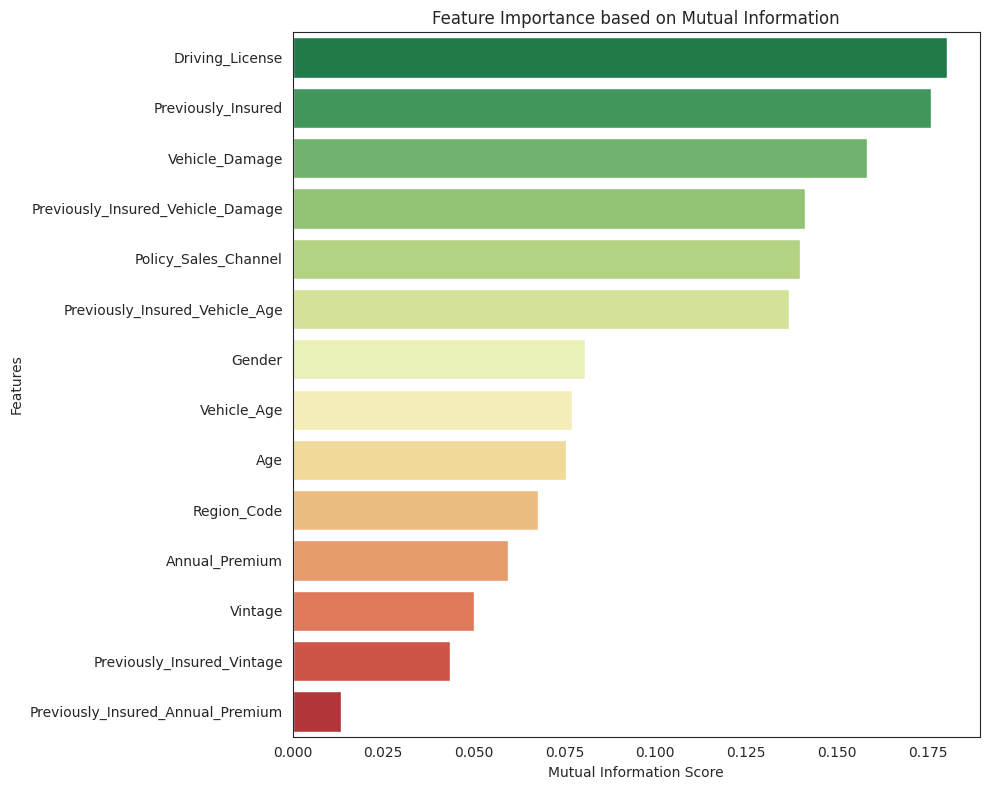

In [6]:
train_mi = train.copy()
train_mi = train.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.background_gradient('RdYlGn')

plt.figure(figsize=(10, 8))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        eval_history = []
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
            val_pool = Pool(X_val, y_val, cat_features=X_val.columns.values)
            test_pool = Pool(X_test, cat_features=X_test.columns.values)
            
            model = clone(self.model)
            model.fit(
                X=train_pool, 
                eval_set=val_pool, 
                verbose=ES_LOG_STEPS, 
                early_stopping_rounds=ES_ROUNDS,
                use_best_model=True
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            eval_history.append(model.get_evals_result())
            
            y_pred_probs = model.predict_proba(val_pool)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(test_pool)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances, eval_history
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516269
        sub['id'] = sub['id'].astype(np.int32)
        sub[TARGET] = np.mean(test_preds, axis=0).astype(np.float16)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'iterations': 5000,
    'random_seed': SEED,
    'verbose': False
}

model = CatBoostClassifier(**params)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances, eval_history = trainer.fit_predict(X, y, test)

Training CatBoostClassifier

Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8664761	best: 0.8664761 (0)	total: 9.44s	remaining: 13h 6m 52s
50:	test: 0.8830598	best: 0.8830598 (50)	total: 51.8s	remaining: 1h 23m 45s
100:	test: 0.8863572	best: 0.8863572 (100)	total: 1m 34s	remaining: 1h 16m 18s
150:	test: 0.8876801	best: 0.8876801 (150)	total: 2m 18s	remaining: 1h 13m 54s
200:	test: 0.8883640	best: 0.8883640 (200)	total: 3m 2s	remaining: 1h 12m 32s
250:	test: 0.8891099	best: 0.8891099 (250)	total: 3m 47s	remaining: 1h 11m 35s
300:	test: 0.8897381	best: 0.8897381 (300)	total: 4m 30s	remaining: 1h 10m 17s
350:	test: 0.8902330	best: 0.8902330 (350)	total: 5m 15s	remaining: 1h 9m 32s
400:	test: 0.8906827	best: 0.8906827 (400)	total: 5m 59s	remaining: 1h 8m 46s
450:	test: 0.8910077	best: 0.8910077 (450)	total: 6m 43s	remaining: 1h 7m 53s
500:	test: 0.8912878	best: 0.8912878 (500)	total: 7m 26s	remaining: 1h 6m 49s
550:	test: 0.8915663	best: 0.8915663 (550)	total: 8m 10s	remaining: 1h 6m
600:	test: 0.8918021	best: 0.8918021 (600)	total: 8m 52s	remaining: 1h

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8663457	best: 0.8663457 (0)	total: 889ms	remaining: 1h 14m 6s
50:	test: 0.8832066	best: 0.8832066 (50)	total: 42.9s	remaining: 1h 9m 26s
100:	test: 0.8862709	best: 0.8862709 (100)	total: 1m 27s	remaining: 1h 10m 34s
150:	test: 0.8876214	best: 0.8876214 (150)	total: 2m 11s	remaining: 1h 10m 24s
200:	test: 0.8883184	best: 0.8883184 (200)	total: 2m 56s	remaining: 1h 10m 13s
250:	test: 0.8890409	best: 0.8890409 (250)	total: 3m 40s	remaining: 1h 9m 25s
300:	test: 0.8896231	best: 0.8896231 (300)	total: 4m 24s	remaining: 1h 8m 49s
350:	test: 0.8901209	best: 0.8901209 (350)	total: 5m 8s	remaining: 1h 8m 8s
400:	test: 0.8906310	best: 0.8906310 (400)	total: 5m 53s	remaining: 1h 7m 32s
450:	test: 0.8909843	best: 0.8909843 (450)	total: 6m 36s	remaining: 1h 6m 43s
500:	test: 0.8912728	best: 0.8912728 (500)	total: 7m 20s	remaining: 1h 5m 56s
550:	test: 0.8915493	best: 0.8915493 (550)	total: 8m 4s	remaining: 1h 5m 13s
600:	test: 0.8917865	best: 0.8917865 (600)	total: 8m 48s	remaining: 1h 4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8663059	best: 0.8663059 (0)	total: 890ms	remaining: 1h 14m 10s
50:	test: 0.8834063	best: 0.8834063 (50)	total: 42.9s	remaining: 1h 9m 25s
100:	test: 0.8863177	best: 0.8863177 (100)	total: 1m 27s	remaining: 1h 10m 21s
150:	test: 0.8877760	best: 0.8877760 (150)	total: 2m 12s	remaining: 1h 10m 57s
200:	test: 0.8883748	best: 0.8883748 (200)	total: 2m 56s	remaining: 1h 10m 9s
250:	test: 0.8890783	best: 0.8890783 (250)	total: 3m 39s	remaining: 1h 9m 12s
300:	test: 0.8897710	best: 0.8897710 (300)	total: 4m 23s	remaining: 1h 8m 32s
350:	test: 0.8903031	best: 0.8903031 (350)	total: 5m 8s	remaining: 1h 8m 10s
400:	test: 0.8906743	best: 0.8906743 (400)	total: 5m 52s	remaining: 1h 7m 26s
450:	test: 0.8910243	best: 0.8910243 (450)	total: 6m 35s	remaining: 1h 6m 31s
500:	test: 0.8913116	best: 0.8913116 (500)	total: 7m 19s	remaining: 1h 5m 46s
550:	test: 0.8915920	best: 0.8915920 (550)	total: 8m 3s	remaining: 1h 5m 2s
600:	test: 0.8918248	best: 0.8918248 (600)	total: 8m 46s	remaining: 1h 4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8665928	best: 0.8665928 (0)	total: 889ms	remaining: 1h 14m 5s
50:	test: 0.8833529	best: 0.8833529 (50)	total: 42.6s	remaining: 1h 8m 53s
100:	test: 0.8863817	best: 0.8863817 (100)	total: 1m 27s	remaining: 1h 10m 20s
150:	test: 0.8878244	best: 0.8878244 (150)	total: 2m 13s	remaining: 1h 11m 24s
200:	test: 0.8884342	best: 0.8884342 (200)	total: 2m 57s	remaining: 1h 10m 36s
250:	test: 0.8891158	best: 0.8891158 (250)	total: 3m 41s	remaining: 1h 9m 49s
300:	test: 0.8897242	best: 0.8897242 (300)	total: 4m 24s	remaining: 1h 8m 49s
350:	test: 0.8902095	best: 0.8902095 (350)	total: 5m 8s	remaining: 1h 8m 6s
400:	test: 0.8906147	best: 0.8906147 (400)	total: 5m 51s	remaining: 1h 7m 14s
450:	test: 0.8909734	best: 0.8909734 (450)	total: 6m 35s	remaining: 1h 6m 29s
500:	test: 0.8912601	best: 0.8912601 (500)	total: 7m 19s	remaining: 1h 5m 44s
550:	test: 0.8915304	best: 0.8915304 (550)	total: 8m 2s	remaining: 1h 4m 57s
600:	test: 0.8917530	best: 0.8917530 (600)	total: 8m 46s	remaining: 1h 4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8654970	best: 0.8654970 (0)	total: 891ms	remaining: 1h 14m 16s
50:	test: 0.8827407	best: 0.8827407 (50)	total: 42.7s	remaining: 1h 9m 7s
100:	test: 0.8859097	best: 0.8859097 (100)	total: 1m 26s	remaining: 1h 10m 14s
150:	test: 0.8873708	best: 0.8873708 (150)	total: 2m 12s	remaining: 1h 10m 47s
200:	test: 0.8879470	best: 0.8879470 (200)	total: 2m 57s	remaining: 1h 10m 29s
250:	test: 0.8886293	best: 0.8886293 (250)	total: 3m 40s	remaining: 1h 9m 34s
300:	test: 0.8892406	best: 0.8892406 (300)	total: 4m 24s	remaining: 1h 8m 44s
350:	test: 0.8897800	best: 0.8897800 (350)	total: 5m 8s	remaining: 1h 8m 7s
400:	test: 0.8902320	best: 0.8902320 (400)	total: 5m 53s	remaining: 1h 7m 32s
450:	test: 0.8905721	best: 0.8905721 (450)	total: 6m 37s	remaining: 1h 6m 45s
500:	test: 0.8908588	best: 0.8908588 (500)	total: 7m 21s	remaining: 1h 6m 3s
550:	test: 0.8911186	best: 0.8911186 (550)	total: 8m 5s	remaining: 1h 5m 18s
600:	test: 0.8913485	best: 0.8913485 (600)	total: 8m 48s	remaining: 1h 4m

# Visualizing The Results

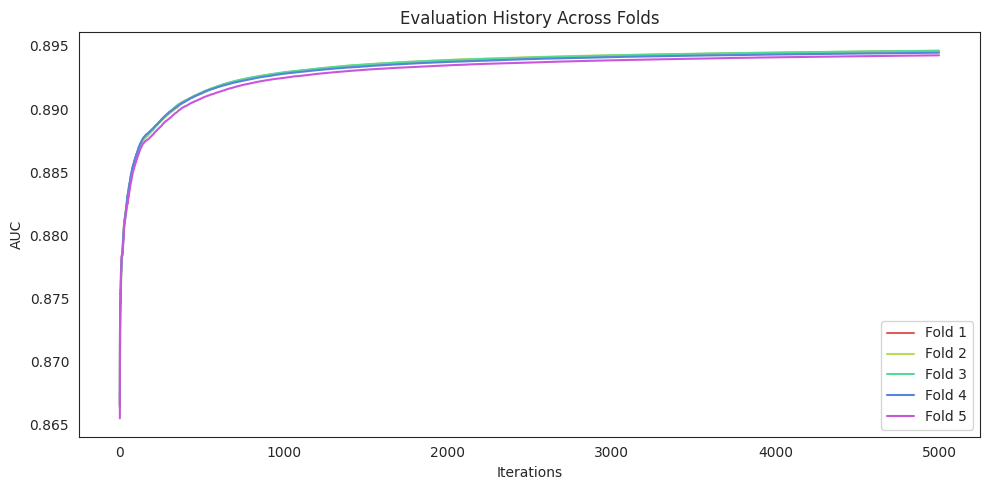

In [9]:
data = []
for fold_idx, fold_eval_history in enumerate(eval_history):
    for metric, values in fold_eval_history['validation'].items():
        if metric != 'AUC':
            continue
        for iteration, auc_value in enumerate(values):
            data.append({'Fold': f'Fold {fold_idx + 1}', 'Metric': metric, 'Iteration': iteration, 'AUC': auc_value})
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Iteration', y='AUC', hue='Fold', palette='hls')
plt.title('Evaluation History Across Folds')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

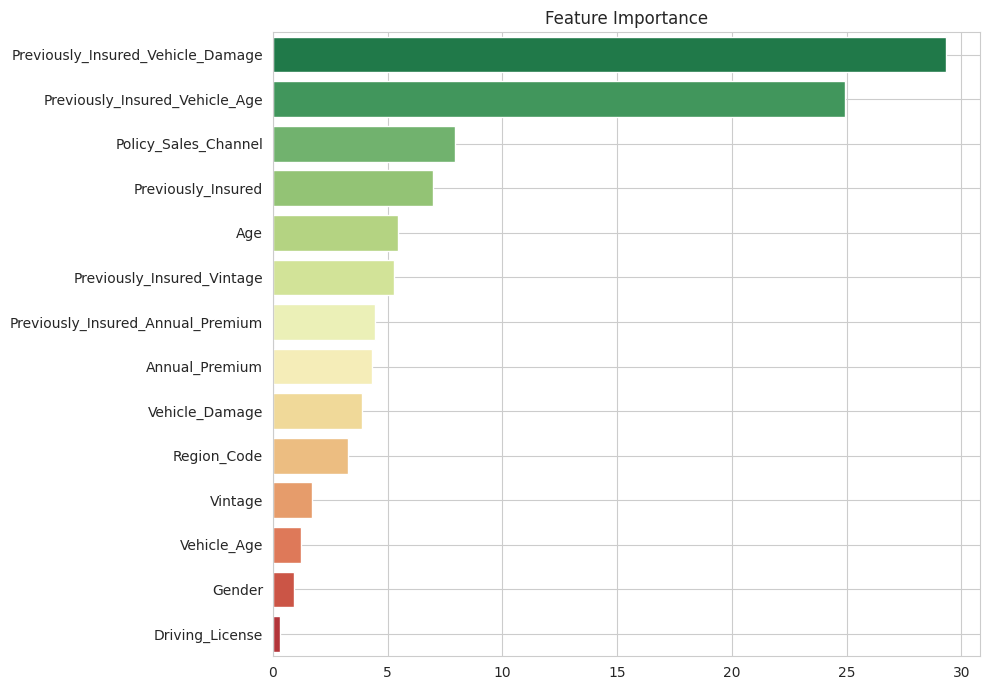

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 7))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

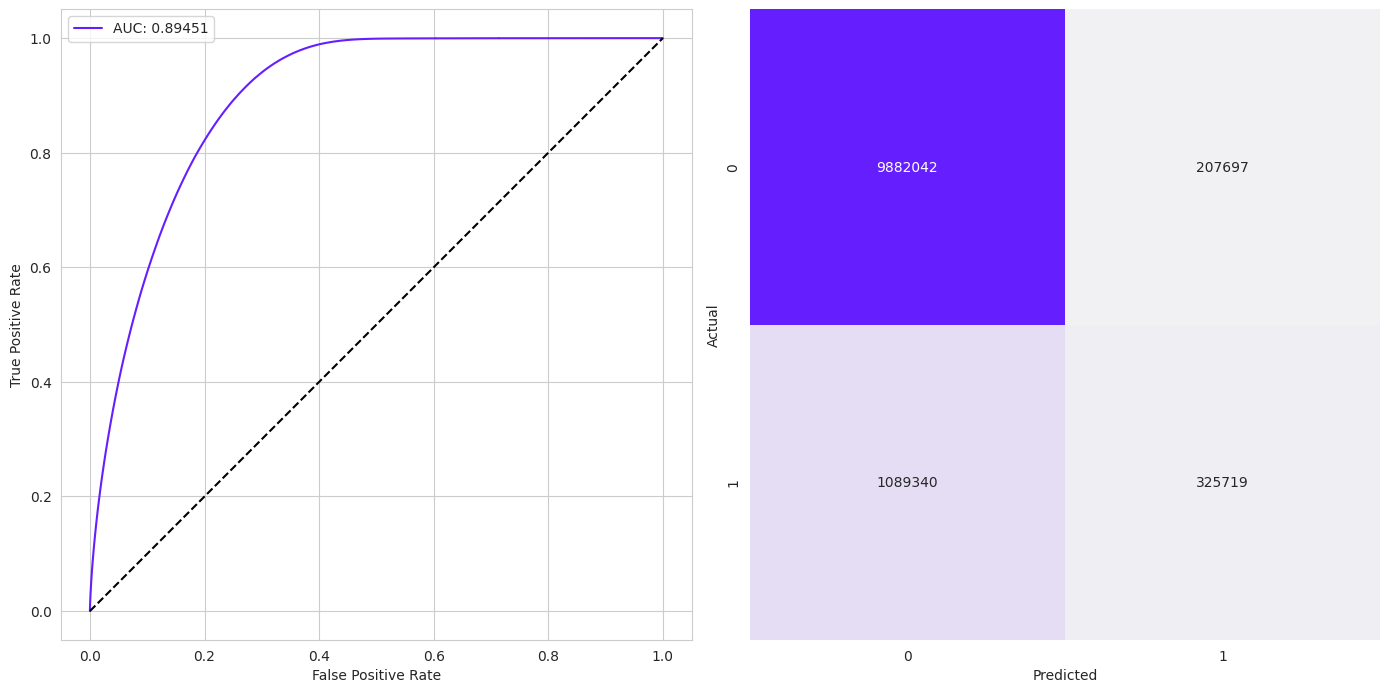

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()